#### Import Standard  Modules ####

In [1]:
import numpy as np #NumPy (numerical python). Enables memory-efficient arrays and related functions

from scipy import io #scipy.io module needed for reading matlab files

from math import pi; #loads the constant Pi

import matplotlib.pyplot as plt #needed for most basic plotting functions
from matplotlib import image #needed for colormap list

In [3]:
pwd

'C:\\Users\\Vandiver\\Documents\\HiFU\\code'

In [4]:
cd '~/Documents/hifu_repos/LabExamples/py'

C:\Users\Vandiver\Documents\hifu_repos\LabExamples\py


### Read PAR/REC ###

In [2]:
#need the 'nibabel' module installed to read MR data
import nibabel

In [5]:
mr_file="../data/scan37_TempSag_20160810.PAR"

mriObj=nibabel.load(mr_file,scaling='fp') #abstract data object encapsulating header and data from PAR/REC


##### Get image data (NumPy array) #####

In [6]:
mriData=mriObj.get_data() #The actual image data array

In [7]:
mriData.shape

(160, 160, 6, 42)

### Compute phase changes: ###

<ol>
    <li> Parse image data set into parts and dynamics (M,R,I,P)</li>
    <li> Compute phase change across dynamics</li>
</ol>

In [86]:
import MRDataAnalysis #custom module with some helper functions I wrote

In [87]:
#Have to know the number of image parts and guess at the slice ordering 

(Mdata , Pdata) = MRDataAnalysis.parse_scan_parts(mriData,num_parts=2,ordering=0)

(nx,ny,nz,ndyn) = Mdata.shape


(nx,ny,nz,ndyn) #last line of a cell will have its output displayed below. could also use print((nx,ny,...))

(160, 160, 6, 21)

In [93]:
#get time points of dynamics
tableStartTimes = mriObj.header.image_defs['dyn_scan_begin_time']
dyntimes = tableStartTimes[range(0,2*ndyn*nz, 2*nz)]

In [80]:
(dx,dy,dz,junk) = mriObj.header.get_zooms() #The voxel sizes

(dx,dy,dz)

(1.512, 1.512, 3.0)

In [11]:
#complex image (Pdata is from -pi to pi)
complexIm = Mdata*np.exp(1j*Pdata)

#now compute phase change between dynamics and the initial baseline 
phaseDiff = np.zeros(complexIm.shape)
for dyn in range(0,ndyn):
    phaseDiff[:,:,:,dyn] = np.angle( complexIm[:,:,:,0] * np.conjugate(complexIm[:,:,:,dyn]) )

##### Simple plot of magnitude data with default colormap #####

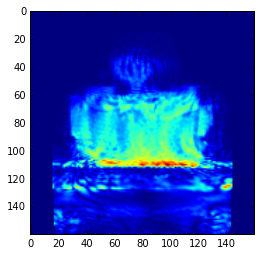

In [12]:
plt.imshow(Mdata[:,:,1,2])

##### Change the  colormap #####

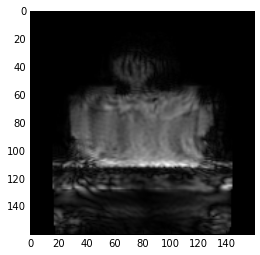

In [13]:
plt.imshow(Mdata[:,:,1,2], cmap=image.cm.gray)

##### Plot the phase change w/ a colorbar #####

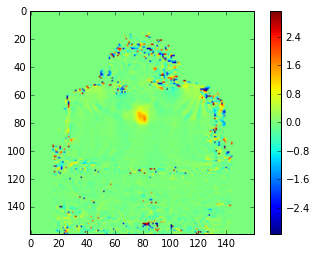

In [14]:
plt.imshow(phaseDiff[:,:,1,-1],cmap=image.cm.jet)
plt.colorbar()

##### Change the range of values plotted w/ vmin and vmax #####

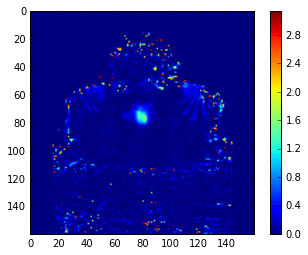

In [15]:
plt.imshow(phaseDiff[:,:,1,-1],cmap=image.cm.jet, vmin=0, vmax=pi)
plt.colorbar()

### Plot image with axes coorinates ###

Use the <b> extent </b> keyword in <b> imshow() </b>.

<b>Note</b> that imshow() transposes the matrix.

<b>Rows</b> (first dimension) are plotted along the <b>Y</b> axis.  

<b>Columns </b> are along the <b>X</b> axis

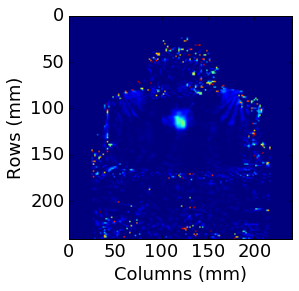

In [16]:
#create axis vectors (I use 'x' to mean the first dimension of imagedata, not the plot axis)
origxp = np.arange(0,nx)*dx  #In MATLAB this would be xp = dx*[0:(nx-1)] 
origyp = np.arange(0,ny)*dy

#define image bounds
left=origyp[0]
right=origyp[-1] #'-1' means the last element
bottom=origxp[-1] 
top=origxp[0]

#plot with extent= keyword
plt.imshow(phaseDiff[:,:,1,-1], extent=(left, right, bottom, top), vmin=0, vmax=pi )
plt.xlabel('Columns (mm)', fontsize=18)
plt.ylabel('Rows (mm)', fontsize=18)

#tick label sizes
axis = plt.gca() #get the current axis handle
axis.tick_params(labelsize=18)

(50, 20)


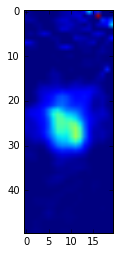

In [17]:
#Zoomed subslice purely for the sake of example

imagedata = phaseDiff[50:100,70:90,1,-1]

print(imagedata.shape)

plt.imshow(imagedata, vmin=0, vmax=pi)

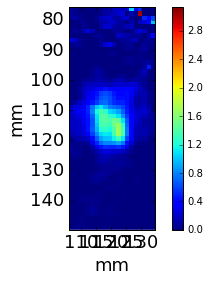

In [18]:
#zoomed vectors
xp = origxp[50:100]
yp = origyp[70:90]


#define image bounds
left=yp[0]
right=yp[-1] #'-1' means the last element
bottom=xp[-1] 
top=xp[0]

plt.imshow(imagedata, extent=(left, right, bottom, top), vmin=0, vmax=pi, interpolation='none' )
plt.xlabel('mm', fontsize=18)
plt.ylabel('mm', fontsize=18)

plt.colorbar()
#tick label sizes
axis = plt.gca() #get the current axis handle
axis.tick_params(labelsize=18)


#axis.locator_params(axis='x',nbins=2)
#axis.locator_params(axis='x',nbins=3)
#axis.locator_params(axis='x',nbins=3,tight=False)
#axis.set_xticks([110.0, 130.0])

### Use a mask to overlay another image ###
Have to create 4-channel image structure.
<ul>
<li>Channel 0-2: R,G,B</li>
<li>Channel 3  : alpha (transparency)</li>
</ul>

##### First scale the contrast image data to be between 0 and 1.0 #####

min,max= (0.0, 1.0)


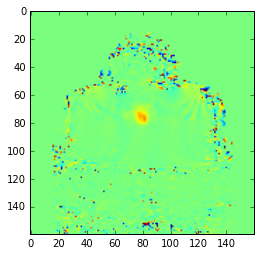

In [19]:
imagedata = phaseDiff[:,:,1,-1]

left=origyp[0]
right=origyp[-1]
bottom=origxp[-1] 
top=origxp[0]

imgMin = np.min(imagedata)
imgMax = np.max(imagedata)

scaledData = (imagedata - imgMin) / (imgMax - imgMin)

print("min,max=",(np.min(scaledData), np.max(scaledData)) )
plt.imshow(imagedata)

##### Define a mask #####

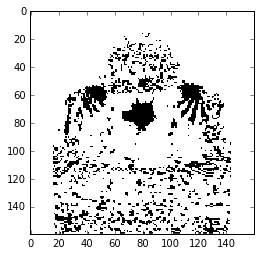

In [20]:
#Mask is derived from the data in this case
exclusion_mask = imagedata < (0.02*pi)
plt.imshow(exclusion_mask,cmap=image.cm.gray,interpolation='none')

##### Now use a color table to convert values in range [0.0, 1.0] to R,G,B values #####

In [21]:
#this returns the image values across R,G,B channels and a transparency ("alpha") channel
contrastImageRGBA = image.cm.hot(scaledData)

print(scaledData.shape)
print(contrastImageRGBA.shape)

(160, 160)
(160, 160, 4)


##### Set the transparency values to the mask #####

In [22]:

contrastImageRGBA[exclusion_mask,3]=0

#equivalent
#contrastImageRGBA[:,:,3]=1-exclusion_mask

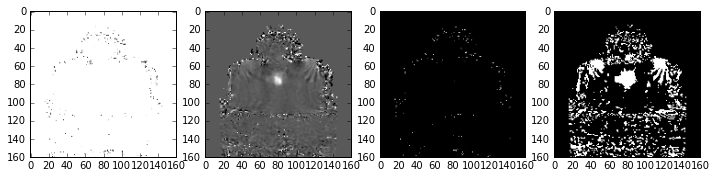

In [23]:
#look at the RGB channels
fig=plt.figure(figsize=(12,4)) #width , height inches

ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.imshow( contrastImageRGBA[:,:,0],cmap=image.cm.gray)
ax2.imshow( contrastImageRGBA[:,:,1],cmap=image.cm.gray)
ax3.imshow( contrastImageRGBA[:,:,2],cmap=image.cm.gray)
ax4.imshow( contrastImageRGBA[:,:,3],cmap=image.cm.gray )

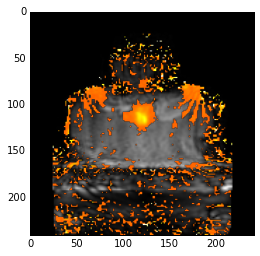

In [24]:
#plot the contrast image on top of a background

backgroundImg = Mdata[:,:,1,0]

plt.imshow(backgroundImg,cmap=image.cm.gray, extent=(left,right,bottom,top))

plt.imshow(contrastImageRGBA, extent=(left,right,bottom,top))

### Colorbar with a contrast image overlay ###

If you simply try plt.colorbar() it won't work as intended.

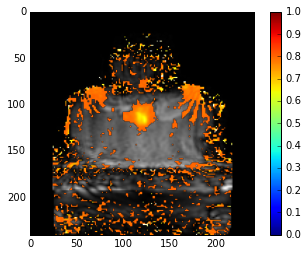

In [25]:
plt.imshow(backgroundImg,cmap=image.cm.gray, extent=(left,right,bottom,top))

plt.imshow(contrastImageRGBA, extent=(left,right,bottom,top))

plt.colorbar()

Instead we have to make a ScalarMappable object and define the colorbar scaling, tick locations, and tick values manually

In [26]:
import matplotlib as mpl

In [27]:
#create scalar mappable with the chosen color lookup table

colorMap = image.cm.hot

sc = mpl.cm.ScalarMappable(cmap=colorMap)

In [28]:
#define data scaling w/ windowing

#imgMin = np.min(imagedata)
#imgMax = np.max(imagedata)

#range over which the color table is applied (anything outside range is clipped)
imgMin = 0.0
imgMax = pi

scaledData = (imagedata - imgMin) / (imgMax - imgMin)

print((np.min(scaledData), np.max(scaledData)))

(-0.99633621968105845, 0.99829137913438704)


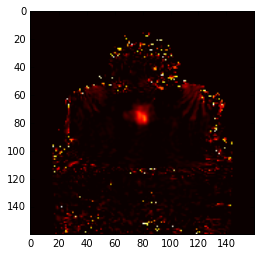

In [29]:
plt.imshow( colorMap(scaledData) )

In [30]:
#Get RGBA array
windowedContrastRGBA = colorMap(scaledData)

#apply the mask
windowedContrastRGBA[:,:,3]=1-exclusion_mask

In [31]:
#Now define colorbar tick points and label stricks

def scaled2value(x):
    return x*(imgMax-imgMin) + imgMin

ticklocations = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

tickstr = ["%0.2f"%scaled2value(x) for x in ticklocations]

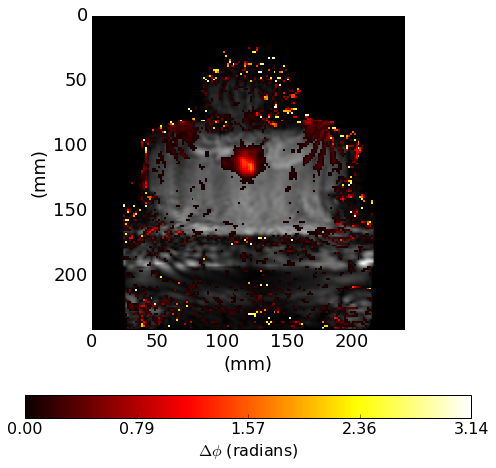

In [32]:
#now create the plot
plt.figure(figsize=(8,8))

plt.imshow(backgroundImg,cmap=image.cm.gray, extent=(left,right,bottom,top))

plt.imshow(windowedContrastRGBA, extent=(left,right,bottom,top), interpolation='none')

plt.xlabel('(mm)', fontsize=18)
plt.ylabel('(mm)', fontsize=18)

#tick label sizes
axis = plt.gca() #get the current axis handle
axis.tick_params(labelsize=18)


# use the ScalarMappable as input to a new colorbar
sc.set_array(ticklocations)
cb=plt.colorbar(mappable=sc,orientation='horizontal')
cb.set_cmap(colorMap)
cb.set_ticks(ticklocations)
cb.set_ticklabels(tickstr)  
cb.set_label('$\Delta \phi$ (radians)',fontsize=16)
cb.ax.tick_params(labelsize=16)

#axis.set_xlim([75,150])
#axis.set_ylim([75,150])

### Quantitative analysis ###

In [33]:
B0_T=3.0
TE_ms=16.0
angle2temp = 1.0 / (42.576*0.01*B0_T*TE_ms*1e-3*2*pi)
temperatureData = phaseDiff*angle2temp

In [50]:
#if the qt4 installed and working, you can do this to make plots in an intercative window
%matplotlib qt4

In [51]:
plt.imshow(temperatureData[:,:,1,-1])

In [53]:
#this just switches back to the default plotting in the notebook
%matplotlib inline

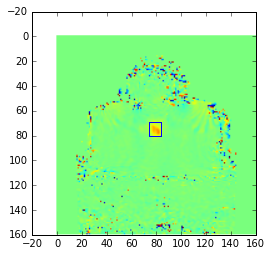

In [55]:
roi0=range(69,81)
roi1=range(74,85)
roi2=range(0,nz)

plt.imshow(temperatureData[:,:,1,-1])
plt.plot([roi1[0], roi1[0], roi1[-1], roi1[-1], roi1[0]], [roi0[0], roi0[-1], roi0[-1], roi0[0], roi0[0]])

#### Select ROI data ####

In [56]:
# This doesn't work like it does in MATLAB
roidata = temperatureData[roi0,roi1,roi2] # WRONG!!!

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (12,) (11,) (6,) 

In [60]:
#Have to use Numpy ix_() function
roidata = temperatureData[np.ix_(roi0,roi1,roi2)]
roidata.shape

(12, 11, 6, 21)

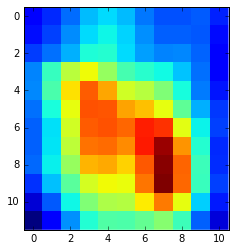

In [63]:
plt.imshow(roidata[:,:,1,-1],interpolation='none')

#### ROI average and max over time ####

In [77]:
avgVsTime = np.mean(roidata,axis=(0,1,2))
maxVsTime = np.max(roidata,axis=(0,1,2))

avgVsTime.shape

# Lots more math and statistics functions in NumPy and SciPy!

(21,)

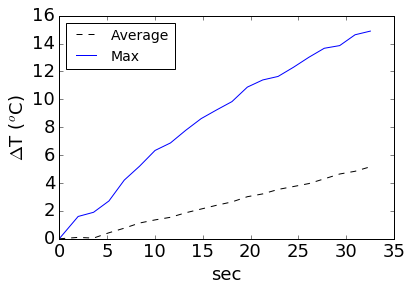

In [94]:
times = dyntimes

plt.plot(times,avgVsTime, 'k--', label='Average')
plt.plot(times,maxVsTime, color='b', label='Max')

plt.ylabel('$\Delta$T ($^o$C)', fontsize=18)
plt.xlabel('sec', fontsize=18)

#tick label sizes
axis = plt.gca() #get the current axis handle
axis.tick_params(labelsize=18)

plt.legend(fontsize=14,loc=2)

#### Histogram of ROI data in the last dynamic ####

In [98]:
(hy,hx) = np.histogram(roidata[:,:,:,-1],bins=30,range=[-5,35],normed=True)        
        
binCenters = (hx[0:-1] + hx[1:] )/2
binWidths=hx[1:]-hx[0:-1]

<Container object of 30 artists>

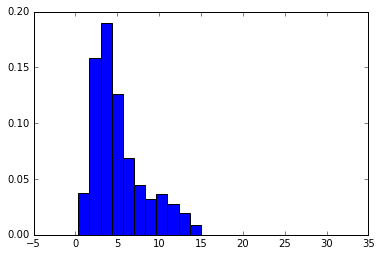

In [103]:
plt.bar(hx[0:-1],hy,width=binWidths)